<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko) 

# <center>Assignment #2. Fall 2019
## <center> Part 2. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

This time we decided to share a pretty decent CatBoost baseline, you'll have to improve the provided solution.

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 
 6. mlcourse.ai tutorials on [categorical feature encoding](https://www.kaggle.com/waydeherman/tutorial-categorical-encoding) (by Wayde Herman) and [CatBoost](https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview) (by Mikhail Tribunskiy)
 7. Last but not the least: [Public Kernels](https://www.kaggle.com/c/flight-delays-fall-2018/notebooks) in this competition

### Your task is to:
 1. beat **"A2 baseline (10 credits)"** on Public LB (**0.75914** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with A1 and the [course rating](https://docs.google.com/spreadsheets/d/15e1K0tg5ponA5R6YQkZfihrShTDLAKf5qeKaoVCiuhQ/) (to appear on 16.09.2019)
 
This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [24]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

**Read the data**

In [25]:
# PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')

In [72]:
train_df = pd.read_csv('flight_delays_train.csv')

In [73]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


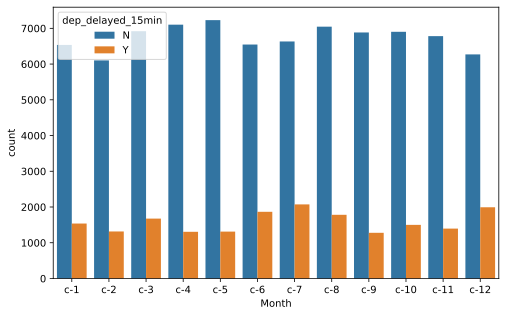

In [74]:
month = pd.unique(train_df['Month'])
month = ['c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7', 'c-8', 'c-9', 'c-10', 'c-11', 'c-12']
# month
sns.countplot(x='Month', hue='dep_delayed_15min', data=train_df, order=month);

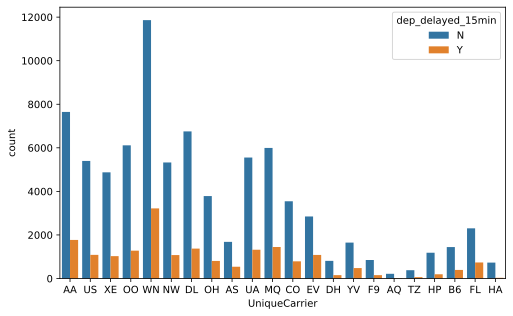

In [75]:
sns.countplot(x='UniqueCarrier', hue='dep_delayed_15min', data=train_df);

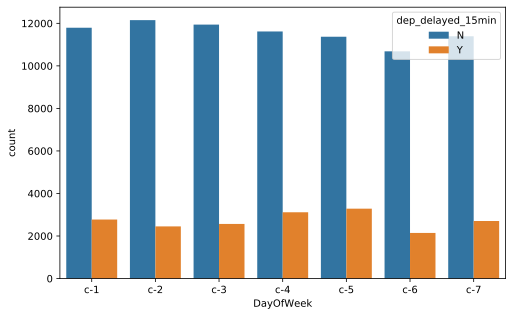

In [76]:
sns.countplot(x='DayOfWeek', hue='dep_delayed_15min', data=train_df, order=['c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7']);

In [77]:
test_df = pd.read_csv('flight_delays_test.csv')

In [78]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


**Create only one feature - “flight” (this you need to improve - add more features)**

In [79]:
# train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
# test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


**Remember indexes of categorical features (to be passed to CatBoost)**

In [80]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 2, 4, 5, 6])

**Allocate a hold-out set (a.k.a. a validation set) to validate the model**

In [81]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [82]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [83]:
ctb = CatBoostClassifier(random_seed=17, silent=True)

In [84]:
%%time
ctb.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);

CPU times: user 2min 20s, sys: 14.7 s, total: 2min 34s
Wall time: 45.1 s


In [85]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

**We got some 0.756 ROC AUC on the hold-out set.**

In [86]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7550839950811625

**Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline**

In [87]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

CPU times: user 3min 13s, sys: 18.5 s, total: 3min 31s
Wall time: 1min


In [90]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]
# feature_importance_df = pd.DataFrame(ctb.get_feature_importance, columns=['feature', 'importance'])
pd.DataFrame(ctb.get_feature_importance())
ctb.feature_importances_

(100000,)

In [ ]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    
#     sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', 
#                              index_col='id')
#     sample_sub['dep_delayed_15min'] = ctb_test_pred
#     sample_sub.to_csv('ctb_pred.csv')

In [ ]:
!head ctb_pred.csv

Now's your turn! Go and improve the model to beat **"A2 baseline (10 credits)"** - **0.75914** LB score. It's crucial to come up with some good features. 

For discussions, stick to the **#a2_kaggle_fall2019** thread in the **mlcourse_ai_news** [ODS Slack](http://opendatascience.slack.com) channel. Serhii Romanenko (@serhii_romanenko) will be there to help. 

Welcome to Kaggle!

<img src='https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg' width=50%>
*from the ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963) thread.*